## Preparation 

In [261]:
import numpy as np
import pandas as pd
from scipy import stats
import psycopg2
import seaborn as sns 

%matplotlib inline
import matplotlib.pyplot as plt

In [262]:
# Connect to database and select csgo.profiles
conn = psycopg2.connect("dbname='dreamteam' user='weisihan' host='localhost' port='5432' password='weisi9527sj'")
cur = conn.cursor()
# load csgo.profiles
cur.execute('SELECT * FROM csgo.profiles')
colnames = [desc[0] for desc in cur.description]
csgo_profiles = cur.fetchall()
cur.close()
conn.close()

### Data Pre-Processing

In [263]:
csgo_profiles = pd.DataFrame(csgo_profiles, columns = colnames)
# data shape
print("data shape:",csgo_profiles.shape)
print("No. of users:",csgo_profiles['user_id'].count())
print()
# print columns
print("There are",csgo_profiles.shape[1],"columns:")
print(colnames)
csgo_profiles.head()

data shape: (84393, 17)
No. of users: 84393

There are 17 columns:
['user_id', 'nickname', 'total_kills', 'total_deaths', 'total_time_played', 'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins', 'total_rounds_played', 'total_shots_fired', 'rank_id', 'goal_id', 'steam_id', 'about', 'updated_at', 'compensation']


,user_id,nickname,total_kills,total_deaths,total_time_played,total_kills_headshot,total_shots_hit,total_mvps,total_wins,total_rounds_played,total_shots_fired,rank_id,goal_id,steam_id,about,updated_at,compensation
0,1,s1rc0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,None,NaT,NaN
1,5,rabbitshu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,None,NaT,NaN
2,3,Mochojojo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN,None,NaT,NaN
3,206,BoyKot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,7.656120e+16,None,2017-12-09 03:10:27.954734+00:00,NaN
4,382,hazzard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN,None,NaT,NaN


In [264]:
csgo_profiles.isnull().sum()

user_id                     0
nickname                    0
total_kills              8474
total_deaths             8471
total_time_played        8466
total_kills_headshot     8480
total_shots_hit          8470
total_mvps               8573
total_wins               8477
total_rounds_played      8468
total_shots_fired        8468
rank_id                     0
goal_id                     0
steam_id                 5925
about                   72854
updated_at               6988
compensation            84392
dtype: int64

In [265]:
# Drop users who haven't played the game (total_time_played != nan)
profiles_plyrs = csgo_profiles.dropna(axis=0, subset=['total_time_played'],how='any')
print("No. of players:",profiles_plyrs['user_id'].count())

#Players must play for some time (total_time_played != 0)
profiles_plyrs = profiles_plyrs[profiles_plyrs['total_time_played']!=0]
print("No. of players:",profiles_plyrs['user_id'].count())

profiles_plyrs.isnull().sum()

No. of players: 75927
No. of players: 75924


user_id                     0
nickname                    0
total_kills                 9
total_deaths                5
total_time_played           0
total_kills_headshot       15
total_shots_hit             5
total_mvps                107
total_wins                 11
total_rounds_played         2
total_shots_fired           3
rank_id                     0
goal_id                     0
steam_id                    8
about                   64770
updated_at                  0
compensation            75924
dtype: int64

In [266]:
# Other Properties - Replace NA values with 0
profiles = profiles_plyrs.copy()
columns = ['total_kills','total_deaths','total_kills_headshot','total_shots_hit','total_mvps','total_wins','total_rounds_played','total_shots_fired']
for c in columns:
    profiles[c] = profiles[c].fillna(0)
print("After replacement:")
print()
print(profiles.isnull().sum())
print()
print("The original:")
print()
print(profiles_plyrs.isnull().sum())

After replacement:

user_id                     0
nickname                    0
total_kills                 0
total_deaths                0
total_time_played           0
total_kills_headshot        0
total_shots_hit             0
total_mvps                  0
total_wins                  0
total_rounds_played         0
total_shots_fired           0
rank_id                     0
goal_id                     0
steam_id                    8
about                   64770
updated_at                  0
compensation            75924
dtype: int64

The original:

user_id                     0
nickname                    0
total_kills                 9
total_deaths                5
total_time_played           0
total_kills_headshot       15
total_shots_hit             5
total_mvps                107
total_wins                 11
total_rounds_played         2
total_shots_fired           3
rank_id                     0
goal_id                     0
steam_id                    8
about                

# Variable Analysis

### Fitting distribution

In [320]:
# function for fitting distributions
def fitDist(distributions,data):
    df_fit = pd.DataFrame(columns=['dist','parms','loglik']) # dataframe to hold fitting results
    # fit distributions
    for dist in distributions:
        parms = dist.fit(data)
        loglik = dist.nnlf(parms,data)
        # add fitting results to the dataframe
        result = pd.DataFrame([dist.name,parms,loglik]).T
        result.columns = df_fit.columns
        df_fit = pd.concat([df_fit,result],ignore_index=True)
    return df_fit

In [321]:
def plot_dists(inputs, name):

    sns.distplot(inputs, bins=150)
    plt.title('Distribution of '+ name)
    moments(inputs, name)
    plt.show()
    
    sns.distplot(inputs, fit= stats.expon,kde=False, bins=150)
    plt.title('Expon distribution of '+ name)
    para_expon = stats.expon.fit(inputs)
    print('Estimated parameters for Expon distribution: \n{} \n{}'.format(para_expon[0],para_expon[1]))
    ks_test_expon = stats.kstest(inputs, 'expon', para_expon)
    mle_expon = stats.expon.nnlf(para_expon, inputs)
    aic_expon = aic(mle_expon, len(para_expon))
    print('\n',ks_test_expon, '\nLoglikelihood: {} \nAIC: {}'.format(mle_expon,aic_expon))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    
    sns.distplot(inputs, fit= stats.norm,kde=False, bins=150)
    plt.title('Norm distribution of '+ name)
    para_norm = stats.norm.fit(inputs)
    print('Estimated parameters for Norm distribution: \n{} \n{}'.format(para_norm[0],para_norm[1]))
    ks_test_norm = stats.kstest(inputs, 'norm', para_norm)
    mle_norm = stats.norm.nnlf(para_norm, inputs)
    aic_norm = aic(mle_norm, len(para_norm))
    print('\n',ks_test_norm, '\nLoglikelihood: {} \nAIC: {}'.format(mle_norm,aic_norm))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    
    sns.distplot(inputs, fit= stats.logistic,kde=False, bins=150)
    plt.title('logistic distribution of '+ name)
    para_logistic = stats.logistic.fit(inputs)
    print('Estimated parameters for Logistic distribution: \n{} \n{}'.format(para_logistic[0],para_logistic[1]))
    ks_test_logistic = stats.kstest(inputs, 'logistic', para_logistic)
    mle_logistic = stats.logistic.nnlf(para_logistic, inputs)
    aic_logistic = aic(mle_logistic, len(para_logistic))
    print('\n',ks_test_logistic, '\nLoglikelihood: {} \nAIC: {}'.format(mle_logistic,aic_logistic))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    
    sns.distplot(inputs, fit= stats.beta,kde=False, bins=150)
    plt.title('beta distribution of '+ name)
    para_beta = stats.logistic.fit(inputs)
    print('Estimated parameters for beta distribution: \n{} \n{}'.format(para_beta[0],para_beta[1]))
    ks_test_beta = stats.kstest(inputs, 'beta', para_beta)
    mle_beta = stats.beta.nnlf(para_beta, inputs)
    aic_beta = aic(mle_beta, len(para_beta))
    print('\n',ks_test_beta, '\nLoglikelihood: {} \nAIC: {}'.format(len(para_beta),aic_beta))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    
    sns.distplot(inputs, fit= stats.t,kde=False, bins=150)
    plt.title('t distribution of '+ name)
    para_t = stats.t.fit(inputs)
    print('Estimated parameters for t distribution: \n{} \n{} \n{}'.format(para_t[0],para_t[1],para_t[2]))
    ks_test_t = stats.kstest(inputs, 't', para_t)
    mle_t = stats.t.nnlf(para_t, inputs)
    aic_t = aic(mle_t, len(para_t))
    print('\n',ks_test_t, '\nLoglikelihood: {} \nAIC: {}'.format(mle_t,aic_t))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    """
    sns.distplot(inputs, fit= stats.chi2,kde=False, bins=150)
    plt.title('Chi2 distribution of '+ name)
    para_chi2 = list(stats.chi2.fit(inputs))
    print('Estimated parameters for Chi2 distribution: \ndf: {} \nloc: {} \nscale: {}'.format(para_chi2[0],para_chi2[1],para_chi2[2]))
    ks_test_chi2 = stats.kstest(inputs, 'chi2', para_chi2)
    mle_chi2 = stats.chi2.nnlf(para_chi2, inputs)
    aic_chi2 = aic(mle_chi2, len(para_chi2))
    print('\n',ks_test_chi2, '\nLoglikelihood: {} \nAIC: {}'.format(mle_chi2,aic_chi2))
    plt.show()
    
    sns.distplot(inputs, fit= stats.dweibull,kde=False, bins=150)
    plt.title('Dweibull distribution of '+ name)
    para_dweibull = list(stats.dweibull.fit(inputs))
    print('Estimated parameters for Dweibull distribution: \ndf: {} \nloc: {} \nscale: {}'.format(para_dweibull[0],para_dweibull[1],para_dweibull[2]))
    ks_test_dweibull = stats.kstest(inputs, 'dweibull', para_dweibull)
    mle_dweibull = stats.dweibull.nnlf(para_dweibull, inputs)
    aic_dweibull = aic(mle_dweibull, len(para_dweibull))
    print('\n',ks_test_dweibull, '\nLoglikelihood: {} \nAIC: {}'.format(mle_dweibull,aic_dweibull))
    plt.show()
    """
    sns.distplot(inputs, fit= stats.lognorm,kde=False, bins=150)
    plt.title('Lognorm distribution of '+ name)
    para_lognorm = stats.lognorm.fit(inputs)
    print('Estimated parameters for Lognorm distribution: \n{} \n{} \n{}'.format(para_lognorm[0],para_lognorm[1],para_lognorm[2]))
    ks_test_lognorm = stats.kstest(inputs, 'lognorm', para_lognorm)
    mle_lognorm = stats.lognorm.nnlf(para_lognorm, inputs)
    aic_lognorm = aic(mle_lognorm, len(para_lognorm))
    print('\n',ks_test_lognorm, '\nLoglikelihood: {} \nAIC: {}'.format(mle_lognorm,aic_lognorm))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    
    sns.distplot(inputs, fit= stats.gamma,kde=False, bins=150)
    plt.title('Gamma distribution of '+ name)
    para_gamma = stats.gamma.fit(inputs)
    print('Estimated parameters for Gamma distribution: \n{} \n{} \n{}'.format(para_gamma[0],para_gamma[1],para_gamma[2]))
    ks_test_gamma = stats.kstest(inputs, 'gamma', para_gamma)
    mle_gamma = stats.gamma.nnlf(para_gamma, inputs)
    aic_gamma = aic(mle_gamma, len(para_gamma))
    print('\n',ks_test_gamma, '\nLoglikelihood: {} \nAIC: {}'.format(mle_gamma,aic_gamma))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    
    sns.distplot(inputs, fit= stats.skewnorm,kde=False, bins=150)
    plt.title('Skewnorm distribution of '+ name)
    para_skewnorm = stats.skewnorm.fit(inputs)
    print('Estimated parameters for Skewnorm distribution: \n{} \n{} \n{}'.format(para_skewnorm[0],para_skewnorm[1],para_skewnorm[2]))
    ks_test_skewnorm = stats.kstest(inputs, 'skewnorm', para_skewnorm)
    mle_skewnorm = stats.skewnorm.nnlf(para_skewnorm, inputs)
    aic_skewnorm = aic(mle_skewnorm, len(para_skewnorm))
    print('\n',ks_test_skewnorm, '\nLoglikelihood: {} \nAIC: {}'.format(mle_skewnorm,aic_skewnorm))
    plt.xlabel('Kill/Death Ratio')
    plt.ylabel('Frequency')
    plt.show()
    """
    sns.distplot(inputs, fit= stats.powerlaw,kde=False, bins=150)
    plt.title('Powerlaw distribution of '+ name)
    para_powerlaw = stats.powerlaw.fit(inputs)
    print('Estimated parameters for Powerlaw distribution: \nbeta: {} \nloc: {} \nscale: {}'.format(para_powerlaw[0],para_powerlaw[1],para_powerlaw[2]))
    ks_test_powerlaw = stats.kstest(inputs, 'powerlaw', para_powerlaw)
    mle_powerlaw = stats.powerlaw.nnlf(para_powerlaw, inputs)
    aic_powerlaw = aic(mle_powerlaw, len(para_powerlaw))
    print('\n',ks_test_powerlaw, '\nLoglikelihood: {} \nAIC: {}'.format(mle_powerlaw,aic_powerlaw))
    plt.show()
    
    sns.distplot(inputs, fit= stats.gennorm,kde=False, bins=150)
    plt.title('Gennorm distribution of '+ name)
    para_gennorm = stats.gennorm.fit(inputs)
    print('Estimated parameters for Gennorm distribution: \nbeta: {} \nloc: {} \nscale: {}'.format(para_gennorm[0],para_gennorm[1],para_gennorm[2]))
    ks_test_gennorm = stats.kstest(inputs, 'gennorm', para_gennorm)
    mle_gennorm = stats.gennorm.nnlf(para_gennorm, inputs)
    aic_gennorm = aic(mle_gennorm, len(para_gennorm))
    print('\n',ks_test_gennorm, '\nLoglikelihood: {} \nAIC: {}'.format(mle_gennorm,aic_gennorm))
    plt.show()
 
    sns.distplot(inputs, fit= stats.gumbel_r,kde=False, bins=150)
    plt.title('Gumbel_r distribution of '+ name)
    para_gumbel_r = stats.gumbel_r.fit(inputs)
    print('Estimated parameters for Gumbel_r distribution: \nloc: {} \nscale: {}'.format(para_gumbel_r[0],para_gumbel_r[1]))
    ks_test_gumbel_r = stats.kstest(inputs, 'gumbel_r', para_gumbel_r)
    mle_gumbel_r = stats.gumbel_r.nnlf(para_gumbel_r, inputs)
    aic_gumbel_r = aic(mle_gumbel_r, len(para_gumbel_r))
    print('\n',ks_test_gumbel_r, '\nLoglikelihood: {} \nAIC: {}'.format(mle_gumbel_r,aic_gumbel_r))
    plt.show()
    
    sns.distplot(inputs, fit= stats.gumbel_l,kde=False, bins=150)
    plt.title('Gumbel_l distribution of '+ name)
    para_gumbel_l = stats.gumbel_l.fit(inputs)
    print('Estimated parameters for Gumbel_l distribution: \nloc: {} \nscale: {}'.format(para_gumbel_l[0],para_gumbel_l[1]))
    ks_test_gumbel_l = stats.kstest(inputs, 'gumbel_l', para_gumbel_l)
    mle_gumbel_l = stats.gumbel_l.nnlf(para_gumbel_l, inputs)
    aic_gumbel_l = aic(mle_gumbel_l, len(para_gumbel_l))
    print('\n',ks_test_gumbel_l, '\nLoglikelihood: {} \nAIC: {}'.format(mle_gumbel_l,aic_gumbel_l))
    plt.show()
    """
    return

### Delete Outlier

In [1]:
# it has a long tail because the data contains a lot of outliers
# so we have to remove them
# this is the function to remove the outliers and calculate the suitbale bin width
def del_outlier (col_of_df):
    q_25 = col_of_df.quantile(0.25)
    q_50 = col_of_df.quantile(0.5)
    q_75 = col_of_df.quantile(0.75)
    print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
    IQR = q_75-q_25
    print("IQR is: ",IQR)
   
    # removing outliers from the data: We only accept data smaller than Q3+3*IQR and larger than Q1-3*IQR
    profiles_without_outlier = col_of_df[np.logical_and(col_of_df <= q_75 + 3*IQR, col_of_df >= q_25 - 3*IQR)]
    
    # optimal width of bins is equal to: 2*IQR*n^(-1/3), n is the number of observations
    width = 2*IQR*np.power(len(profiles_without_outlier),-1/3)
    print("bin width is: ", width)
    
    return profiles_without_outlier, width

### Fitting into distribution

In [323]:
def moments(inputs, name):
    mean = inputs.mean()
    var = inputs.var()
    skew = inputs.skew()
    kurt = inputs.kurtosis()
    print("{}'s four moments: \nMean: {} \nVariance: {} \nSkewness: {} \nKurtosis: {}".format(name, mean,var,skew,kurt))
    return

In [324]:
def aic(loglik, NE):
    return 2*loglik+2*NE

In [325]:
def get_data(colname):
    data = np.log(profiles[colname].dropna(axis=0)+0.000000001)
    name = colname.replace('_', ' ').capitalize()
    return data, name

In [326]:
def report(colname):
    data, name = get_data(colname)
    plot_dists(data, name)
    return

### 1. Total Kill/Total Death

In [274]:
a=profiles.copy() 
a.loc[a['total_deaths'] ==0,'total_deaths']=1  

In [275]:
((a["total_deaths"]==0)==True).sum()

0

Text(0.5,1,'b) Distribution Plot of Kill/Death Ratio (without Removing Outliers)')

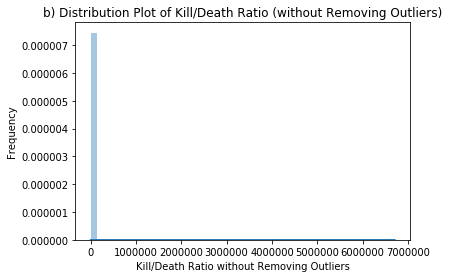

In [276]:
kill_death = profiles["total_kills"]/a["total_deaths"] 
kill_death.head()

sns.distplot(kill_death, kde_kws={"shade": True})
plt.xlabel('Kill/Death Ratio without Removing Outliers')
plt.ylabel('Frequency')
plt.title('b) Distribution Plot of Kill/Death Ratio (without Removing Outliers)')
#bad plot, can't see the trend clearly

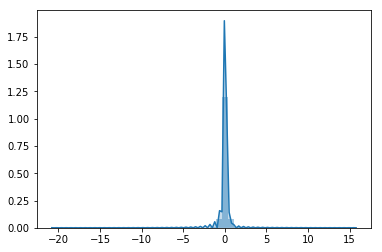

In [277]:
#So if we take log and plot
kill_death_log = np.log(0.000000001 + kill_death)
sns.distplot(kill_death_log, kde_kws={"shade": True})


In [278]:
#kill_death_without_outliers,binwidth = del_outlier (kill_death)

q_25 is:  0.9146833731954205 , q_50 is:  1.0388159180674514 , q_75 is:  1.1826200890188332
IQR is:  0.2679367158234127
bin width is:  0.0127710841912


In [279]:
kill_death_without_outliers=kill_death[kill_death<10]

In [280]:
q_25 = kill_death_without_outliers.quantile(0.25)
q_50 = kill_death_without_outliers.quantile(0.5)
q_75 = kill_death_without_outliers.quantile(0.75)
print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
IQR = q_75-q_25
print("IQR is: ",IQR)
hit_fired_without_outliers.min()

q_25 is:  0.914274615459441 , q_50 is:  1.0383350676378773 , q_75 is:  1.181094977526778
IQR is:  0.26682036206733706


0.0

In [281]:
kill_death_without_outliers.min()

0.0

Text(0.5,1,'b) Frequency Plot for Kill/Death Ratio')

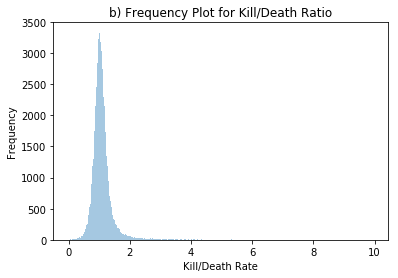

In [260]:
#Plot the distribution of kill death rate (with out outlier), now it is quite better
sns.distplot(kill_death_without_outliers, kde_kws={"shade": True},kde=False, bins=500)
plt.xlabel('Kill/Death Rate')
plt.ylabel('Frequency')
plt.title('b) Frequency Plot for Kill/Death Ratio')

In [282]:
# call function to fit distributions to 'kill_death' data
distributions = [stats.beta, stats.expon,stats.norm,stats.logistic,stats.t,stats.chi2,
                 stats.dweibull,stats.lognorm,stats.gamma,stats.skewnorm,stats.f,stats.powerlaw]
df_fit = fitDist(distributions,kill_death_without_outliers)
# order by loglik
df_fit_order = df_fit.copy()
print(df_fit_order.sort_values(by='loglik',ascending=True))

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


        dist                                              parms   loglik
4          t     (2.13235829288, 1.03403218209, 0.159801205997)  6923.02
6   dweibull    (0.862010098833, 1.03276428333, 0.202413388463)  12281.7
7    lognorm   (0.268242718583, -0.106481285765, 1.15928294803)  19000.5
3   logistic                    (1.05229737806, 0.162443607764)  19868.8
0       beta  (10.3765045212, 1.86776462212e+12, -0.01716910...  25022.1
9   skewnorm    (4.33828966008, 0.690414705363, 0.632244944236)  30889.9
2       norm                    (1.10267948415, 0.479345918188)  51775.6
1      expon                (-9.03287750121e-10, 1.10270263348)    83142
5       chi2  (1.70631993042, -8.44415745742e-28, 1.29182518...   101976
10         f  (1.65476094561, 1.16166556551, -1.64388433927e...   128178
11  powerlaw  (0.445111648632, -2.28413528101e-27, 10.208265...   141317
8      gamma  (0.272410987439, -2.39371851594e-25, 18.041732...   157247


kill/death ratio's four moments: 
Mean: 1.1026794841503964 
Variance: 0.22977554306448028 
Skewness: 7.7528462495795605 
Kurtosis: 97.24062044522938


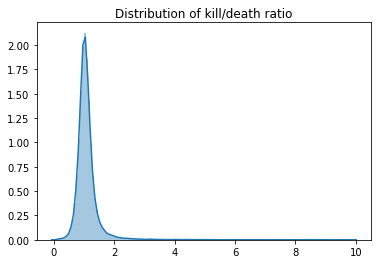

Estimated parameters for Expon distribution: 
-9.0328775012074e-10 
1.1027026334813006

 KstestResult(statistic=0.42444808213838298, pvalue=0.0) 
Loglikelihood: 83141.96567668235 
AIC: 166287.9313533647


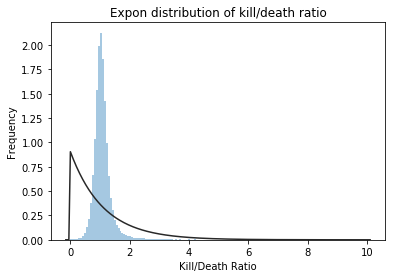

Estimated parameters for Norm distribution: 
1.1026794841503964 
0.47934591818792904

 KstestResult(statistic=0.20296612162670158, pvalue=0.0) 
Loglikelihood: 51775.616535684356 
AIC: 103555.23307136871


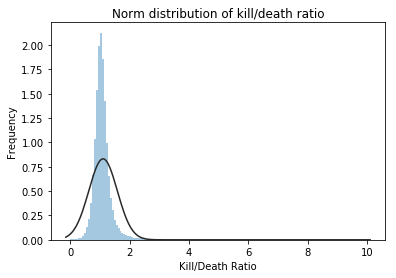

Estimated parameters for Logistic distribution: 
1.0522973780579012 
0.1624436077639354

 KstestResult(statistic=0.067915573694090597, pvalue=7.2640007833604197e-304) 
Loglikelihood: 19868.756534675747 
AIC: 39741.513069351495


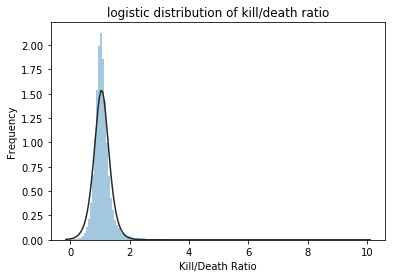

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Estimated parameters for beta distribution: 
1.0522973780579012 
0.1624436077639354

 KstestResult(statistic=0.58224956759397406, pvalue=0.0) 
Loglikelihood: inf 
AIC: inf


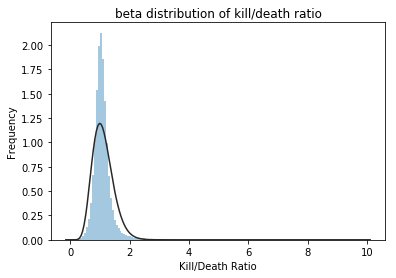

Estimated parameters for t distribution: 
2.1323582928765155 
1.034032182086754 
0.1598012059967694

 KstestResult(statistic=0.035177207790645718, pvalue=7.8522670247796685e-82) 
Loglikelihood: 6923.017084585095 
AIC: 13852.03416917019


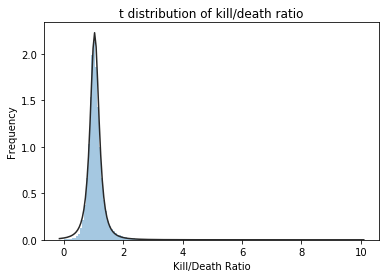

Estimated parameters for Lognorm distribution: 
0.2682427185831726 
-0.10648128576514548 
1.1592829480302336

 KstestResult(statistic=0.10318714916224025, pvalue=0.0) 
Loglikelihood: 19000.544396014928 
AIC: 38007.088792029856


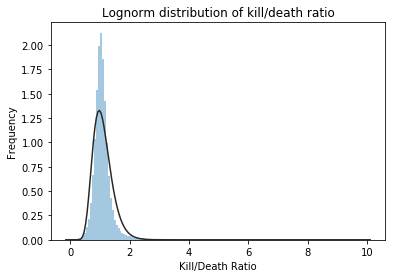

Estimated parameters for Gamma distribution: 
0.2724109874386566 
-2.3937185159444687e-25 
18.041732248365726

 KstestResult(statistic=0.41507469024205845, pvalue=0.0) 
Loglikelihood: 157247.0947259899 
AIC: 314500.1894519798


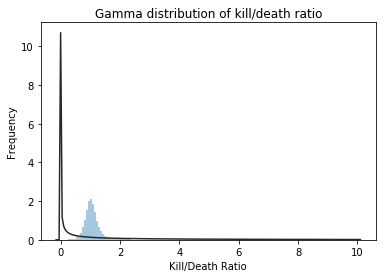

Estimated parameters for Skewnorm distribution: 
4.3382896600813385 
0.6904147053629308 
0.6322449442362899

 KstestResult(statistic=0.19980216290586739, pvalue=0.0) 
Loglikelihood: 30889.94839519944 
AIC: 61785.89679039888


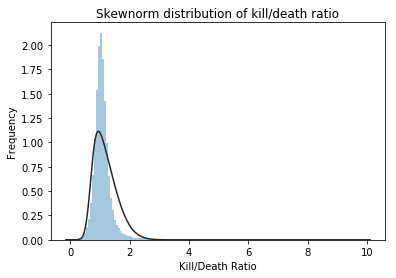

In [283]:
data = kill_death_without_outliers
name = "kill/death ratio"

plot_dists(data, name)

### 2. Hit/shot rate

b=profiles.copy() 
b.loc[b['total_shots_fired'] ==0,'total_shots_fired']=1  

In [285]:
((b["total_shots_fired"]==0)==True).sum()

0

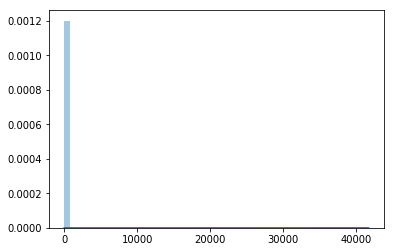

In [286]:
hit_fired = profiles["total_shots_hit"]/a["total_shots_fired"] 
hit_fired.head()

hit_fired = hit_fired.dropna()

sns.distplot(hit_fired, kde_kws={"shade": True})
#bad plot, can't see the trend clearly

In [287]:
hit_fired.isnull().sum()
hit_fired.head()

5     0.727273
8     0.176158
10    0.174500
11    0.107234
12    0.195682
dtype: float64

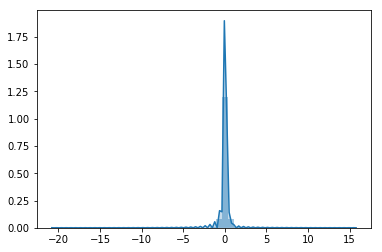

In [241]:
#So if we take log and plot
hit_fired_log = np.log(0.000000001 + kill_death)
sns.distplot(hit_fired_log, kde_kws={"shade": True})

In [288]:
#hit_fired_without_outliers,binwidth = del_outlier (hit_fired)
hit_fired_without_outliers = hit_fired[hit_fired<1]

In [289]:
q_25 = hit_fired_without_outliers.quantile(0.25)
q_50 = hit_fired_without_outliers.quantile(0.5)
q_75 = hit_fired_without_outliers.quantile(0.75)
print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
IQR = q_75-q_25
print("IQR is: ",IQR)
hit_fired_without_outliers.min()

q_25 is:  0.16754585027759356 , q_50 is:  0.1845556539805461 , q_75 is:  0.202654709616771
IQR is:  0.035108859339177456


0.0

Text(0.5,1,'c) Frequency Plot for Hit/Shot Rate (Accuracy)')

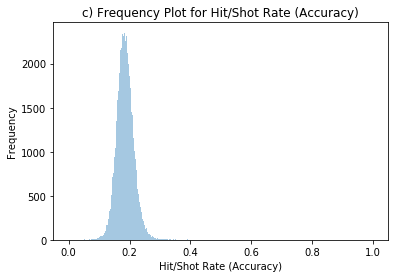

In [243]:
#Plot the distribution of hit fire rate (with out outlier), now it is quite better
sns.distplot(hit_fired_without_outliers, kde_kws={"shade": True},kde=False, bins=500)
plt.xlabel('Hit/Shot Rate (Accuracy)')
plt.ylabel('Frequency')
plt.title('c) Frequency Plot for Hit/Shot Rate (Accuracy)')

In [162]:
# call function to fit distributions to 'hit_fired' data
distributions = [stats.expon,stats.norm,stats.logistic,stats.t,stats.chi2,
                 stats.dweibull,stats.lognorm,stats.gamma,stats.skewnorm,stats.f,stats.powerlaw]
df_fit = fitDist(distributions,hit_fired_without_outliers)
# order by loglik
df_fit_order = df_fit.copy()
print(df_fit_order.sort_values(by='loglik',ascending=True))

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


        dist                                              parms   loglik
3          t    (5.6517269984, 0.184963585726, 0.0235888720077)  -162784
2   logistic                  (0.185118922558, 0.0159731861702)  -161660
5   dweibull   (1.11802357961, 0.184940878737, 0.0231909147274)  -161224
6    lognorm   (0.1238745732, -0.0559642762088, 0.240294763064)  -159078
4       chi2  (89.235605744, -0.0167217467277, 0.0022744020025)  -158091
8   skewnorm   (2.02110313518, 0.155172159097, 0.0450150359858)  -156784
1       norm                  (0.186233110774, 0.0325815307812)  -152217
0      expon               (-2.19891032506e-10, 0.186228559051) -51680.3
10  powerlaw  (0.590631599295, -4.12097704908e-19, 1.0020933... -12613.4
9          f  (1.57396723291, 1.46783505097, -3.04633569407e... -9825.21
7      gamma  (0.423449333402, -1.17105259536e-28, 1.4145652...  2989.63


hit/fired's four moments: 
Mean: 0.18623311077422877 
Variance: 0.0010615701315324073 
Skewness: 4.411633472657685 
Kurtosis: 82.84559355023038


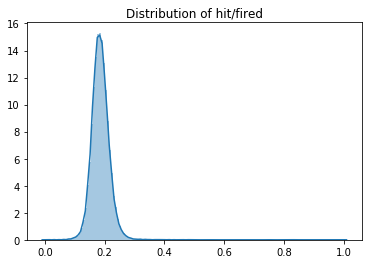

Estimated parameters for Expon distribution: 
-2.198910325058966e-10 
0.18622855905064856

 KstestResult(statistic=0.48843183606616902, pvalue=0.0) 
Loglikelihood: -51680.28044907862 
AIC: -103356.56089815724


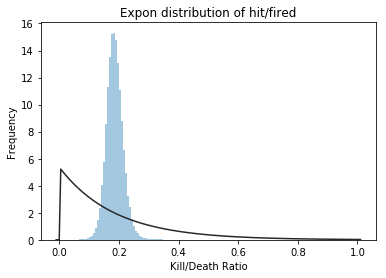

Estimated parameters for Norm distribution: 
0.18623311077422877 
0.032581530781240646

 KstestResult(statistic=0.058121677673031891, pvalue=3.5306341468578325e-223) 
Loglikelihood: -152216.98206126332 
AIC: -304429.96412252664


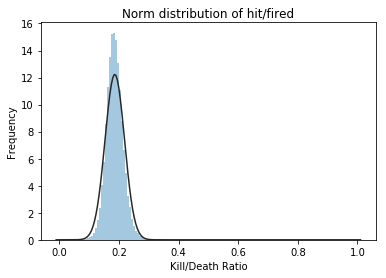

Estimated parameters for Logistic distribution: 
0.18511892255773962 
0.01597318617016543

 KstestResult(statistic=0.015564906070871298, pvalue=2.1185494986959212e-16) 
Loglikelihood: -161660.17398188083 
AIC: -323316.34796376165


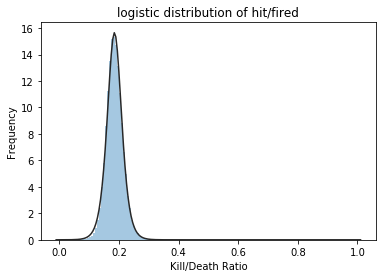

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Estimated parameters for beta distribution: 
0.18511892255773962 
0.01597318617016543

 KstestResult(statistic=0.92935191191236755, pvalue=0.0) 
Loglikelihood: inf 
AIC: inf


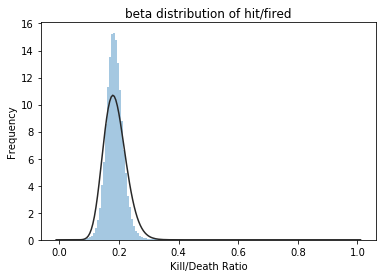

Estimated parameters for t distribution: 
5.651726998397423 
0.18496358572649677 
0.023588872007731396

 KstestResult(statistic=0.013448455346534376, pvalue=2.3718929578057084e-12) 
Loglikelihood: -162784.39873611872 
AIC: -325562.79747223743


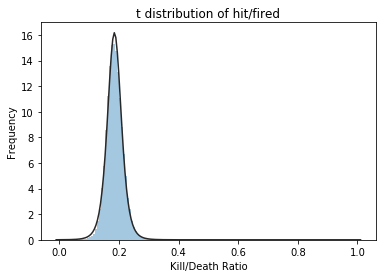

Estimated parameters for Lognorm distribution: 
0.12387457319958092 
-0.055964276208767844 
0.24029476306372827

 KstestResult(statistic=0.031344117729373205, pvalue=3.2978329868332589e-65) 
Loglikelihood: -159078.30166948272 
AIC: -318150.60333896545


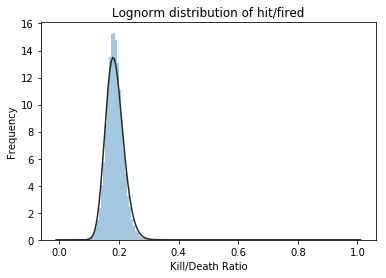

Estimated parameters for Gamma distribution: 
0.4234493334021544 
-1.1710525953599917e-28 
1.4145652180668717

 KstestResult(statistic=0.46639952058489398, pvalue=0.0) 
Loglikelihood: 2989.6344114495587 
AIC: 5985.268822899117


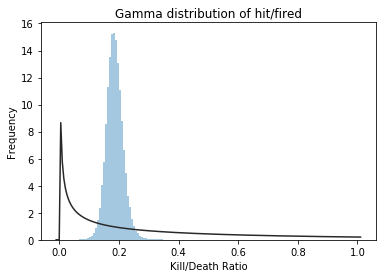

Estimated parameters for Skewnorm distribution: 
2.0211031351762108 
0.15517215909739862 
0.04501503598583304

 KstestResult(statistic=0.047679139403555282, pvalue=2.5122399806649018e-150) 
Loglikelihood: -156783.6791244619 
AIC: -313561.3582489238


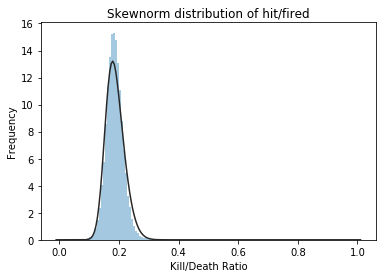

In [290]:
data = hit_fired_without_outliers
name = "hit/fired"

plot_dists(data, name)

### 3. Total Wins /Total Rounds (Winning Rate)

In [297]:
c=profiles.copy() 
c.loc[c['total_rounds_played'] ==0,'total_rounds_played']=1  

In [298]:
((c["total_rounds_played"]==0)==True).sum()

0

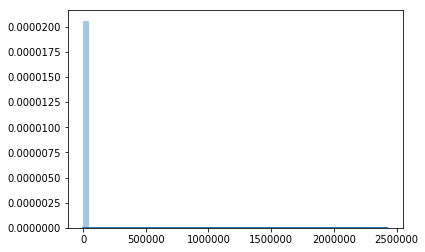

In [299]:
win_rounds = profiles["total_wins"]/c["total_rounds_played"] # this is kill per second
win_rounds.head()

win_rounds = win_rounds.dropna()

sns.distplot(win_rounds, kde_kws={"shade": True})
#bad plot, can't see the trend clearly

In [294]:
win_rounds.isnull().sum()
win_rounds.head()

5     0.125000
8     0.507693
10    0.549020
11    0.550000
12    0.506329
dtype: float64

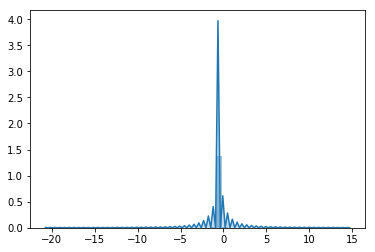

In [254]:
#So if we take log and plot
win_rounds_log = np.log(0.000000001 + win_rounds)
sns.distplot(win_rounds_log, kde_kws={"shade": True})

In [300]:
#win_rounds_without_outliers,binwidth = del_outlier (win_rounds)
win_rounds_without_outliers = win_rounds[win_rounds<1]

Text(0.5,1,'d) Frequency Plot for Winning Rate')

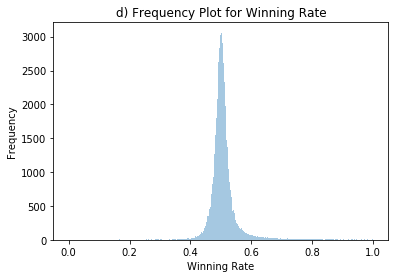

In [256]:
#Plot the distribution of hit fire rate (with out outlier), now it is quite better
sns.distplot(win_rounds_without_outliers, kde_kws={"shade": True},kde=False, bins=500)
plt.xlabel('Winning Rate')
plt.ylabel('Frequency')
plt.title('d) Frequency Plot for Winning Rate')

In [301]:
q_25 = win_rounds_without_outliers.quantile(0.25)
q_50 = win_rounds_without_outliers.quantile(0.5)
q_75 = win_rounds_without_outliers.quantile(0.75)
print("q_25 is: ", q_25,", q_50 is: ", q_50,", q_75 is: ", q_75)
IQR = q_75-q_25
print("IQR is: ",IQR)
hit_fired_without_outliers.min()

q_25 is:  0.4885069033615662 , q_50 is:  0.5022496818797502 , q_75 is:  0.5175829555554827
IQR is:  0.029076052193916513


0.0

In [259]:
win_rounds_without_outliers.min()

0.0

In [161]:
distributions = [stats.expon,stats.norm,stats.logistic,stats.t,stats.chi2,
                 stats.dweibull,stats.lognorm,stats.gamma,stats.skewnorm,stats.f,stats.powerlaw]
df_fit = fitDist(distributions,win_rounds_without_outliers)
# order by loglik
df_fit_order = df_fit.copy()
print(df_fit_order.sort_values(by='loglik',ascending=True))

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


        dist                                              parms   loglik
3          t    (1.5504746705, 0.501551244905, 0.0165788379902)  -147907
5   dweibull  (0.795833976511, 0.501788362558, 0.0245521027298)  -143217
2   logistic                   (0.50381215702, 0.0215707205222)  -129774
8   skewnorm    (1.59999118616, 0.46102797459, 0.0752502214144)  -111330
6    lognorm  (0.0460976228035, -0.720535893929, 1.22807742293)  -108801
4       chi2  (300.01423861, -0.213447038341, 0.00240280395752)  -107944
1       norm                  (0.508860820455, 0.0580903371492)  -106869
7      gamma  (91.0360853568, -0.179306963261, 0.0075198528862)  -104404
10  powerlaw  (1.46370074352, -0.000151603474768, 1.00294924... -4480.98
0      expon               (-2.99430328665e-11, 0.504157948575)  24302.2
9          f  (1.52882352208, 2.34802906118, -1.73736468701e...    57214


win_rounds's four moments: 
Mean: 0.5088472330793731 
Variance: 0.0033813562084865985 
Skewness: 2.044423702751552 
Kurtosis: 22.43624918996438


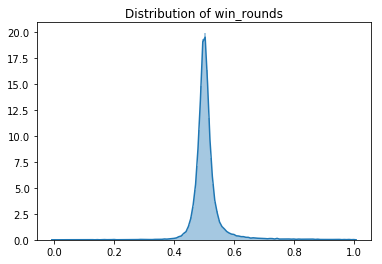

Estimated parameters for Expon distribution: 
-2.99430328665254e-11 
0.5041579485748207

 KstestResult(statistic=0.55743759427575656, pvalue=0.0) 
Loglikelihood: 24300.87164800061 
AIC: 48605.74329600122


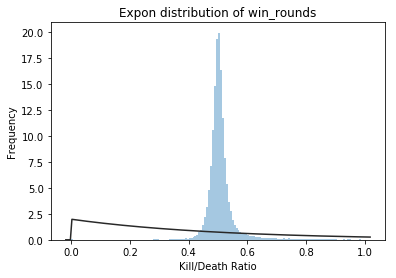

Estimated parameters for Norm distribution: 
0.5088472330793731 
0.058149041821420715

 KstestResult(statistic=0.20722216759611223, pvalue=0.0) 
Loglikelihood: -106795.82172928336 
AIC: -213587.64345856672


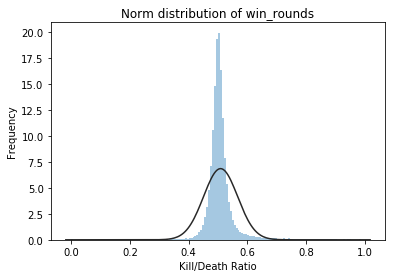

Estimated parameters for Logistic distribution: 
0.5038122857536695 
0.02158107817300916

 KstestResult(statistic=0.096388800443777511, pvalue=0.0) 
Loglikelihood: -129735.36732026847 
AIC: -259466.73464053695


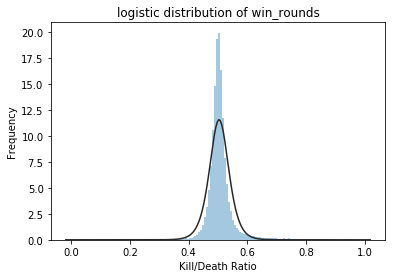

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Estimated parameters for beta distribution: 
0.5038122857536695 
0.02158107817300916

 KstestResult(statistic=0.93432902084525438, pvalue=0.0) 
Loglikelihood: inf 
AIC: inf


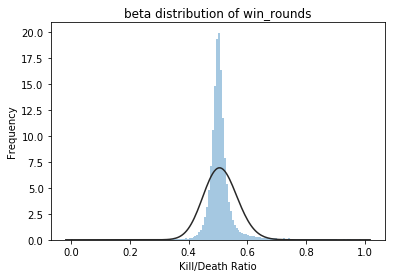

Estimated parameters for t distribution: 
1.5499564384954603 
0.5015509901397956 
0.016577975567177564

 KstestResult(statistic=0.027341742632903662, pvalue=4.6214434952715589e-49) 
Loglikelihood: -147896.51882980965 
AIC: -295787.0376596193


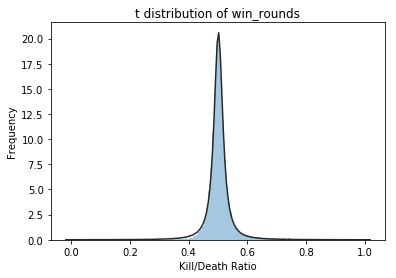

Estimated parameters for Lognorm distribution: 
0.04535609516080488 
-0.7427799137671574 
1.2503272477568204

 KstestResult(statistic=0.19656836046370463, pvalue=0.0) 
Loglikelihood: -108672.98711482555 
AIC: -217339.9742296511


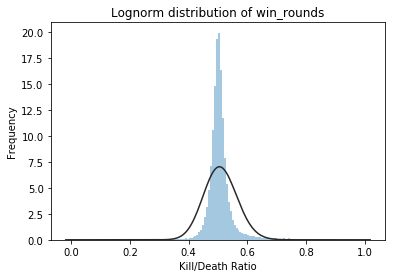

Estimated parameters for Gamma distribution: 
195.6027797041453 
-0.2969210785897186 
0.0041218866930643056

 KstestResult(statistic=0.20110025760543526, pvalue=0.0) 
Loglikelihood: -108134.77062505222 
AIC: -216263.54125010443


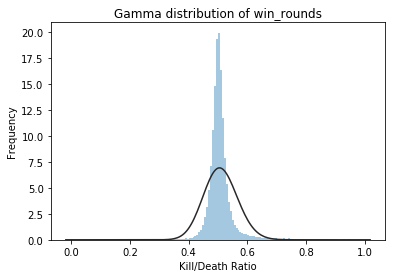

Estimated parameters for Skewnorm distribution: 
1.5912500948193147 
0.4610507372081949 
0.0752709815165564

 KstestResult(statistic=0.20092479379233386, pvalue=0.0) 
Loglikelihood: -111195.44907810833 
AIC: -222384.89815621666


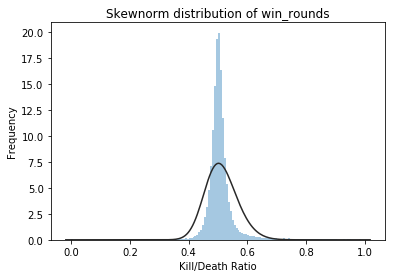

In [302]:
data = win_rounds_without_outliers
name = "win_rounds"

plot_dists(data, name)

### 4. Total Time Played

In [307]:
total_time=profiles["total_time_played"]
total_time.count()

75924

In [308]:
total_time_played_without_outlier, bins=del_outlier (total_time)

q_25 is:  652465.75 , q_50 is:  1489140.0 , q_75 is:  2785035.5
IQR is:  2132569.75
bin width is:  100979.016524


In [309]:
total_time_played_without_outlier1, bins1=del_outlier (total_time/60)
total_time_played_without_outlier1.max()

q_25 is:  10874.429166666667 , q_50 is:  24819.0 , q_75 is:  46417.25833333333
IQR is:  35542.82916666666
bin width is:  1682.98360873


153018.71666666667

In [310]:
total_time_played_without_outlier.count()

75354

In [188]:
total_time.max()

2000205778.0

In [186]:
#total_time_played_without_outlier=total_time_played_without_outlier/60
total_time_played_without_outlier.max()

9181123.0

Text(0.5,1,'a) Frequency Plot for Total Time Played (in min)')

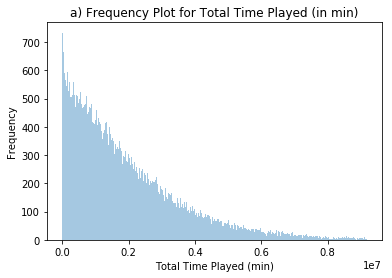

In [196]:
sns.distplot(total_time_played_without_outlier, kde_kws={"shade": True},kde=False, bins=500)
plt.xlabel('Total Time Played (min)')
plt.ylabel('Frequency')
plt.title('a) Frequency Plot for Total Time Played (in min)')

In [147]:
moments(hit_fired_without_outliers, "name")

name's four moments: 
Mean: 0.18623311077422877 
Variance: 0.0010615701315324073 
Skewness: 4.411633472657685 
Kurtosis: 82.84559355023038


In [327]:
hit_fired_without_outliers.head()

5     0.727273
8     0.176158
10    0.174500
11    0.107234
12    0.195682
dtype: float64

total time's four moments: 
Mean: 1924202.4057117074 
Variance: 2797407664811.619 
Skewness: 1.3277291184336675 
Kurtosis: 1.7294160134005176


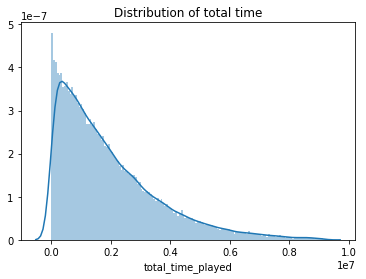

Estimated parameters for Expon distribution: 
-203520924.4274612 
1855203.0682809753

 KstestResult(statistic=1.0, pvalue=0.0) 
Loglikelihood: 9432321.799005177 
AIC: 18864647.598010354


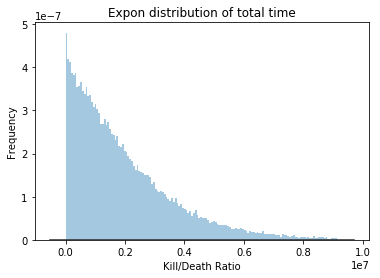

Estimated parameters for Norm distribution: 
1924202.4057117074 
1672534.1674434908

 KstestResult(statistic=0.12498452196509613, pvalue=0.0) 
Loglikelihood: 1186734.2487885556 
AIC: 2373472.4975771112


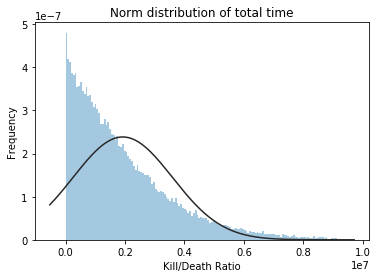

Estimated parameters for Logistic distribution: 
1703624.6805444253 
898831.3296676303

 KstestResult(statistic=0.13064240064046692, pvalue=0.0) 
Loglikelihood: 1184404.082034127 
AIC: 2368812.164068254


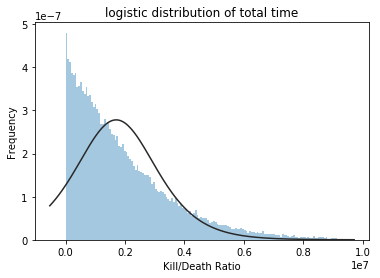

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Estimated parameters for beta distribution: 
1703624.6805444253 
898831.3296676303

 KstestResult(statistic=1.0, pvalue=0.0) 
Loglikelihood: 2 
AIC: inf


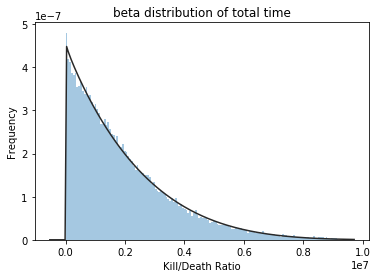

Estimated parameters for t distribution: 
0.12239897543045 
1422239.23515045 
719.5551579447585

 KstestResult(statistic=0.26559688342895482, pvalue=0.0) 
Loglikelihood: 1312879.4851726557 
AIC: 2625764.9703453113


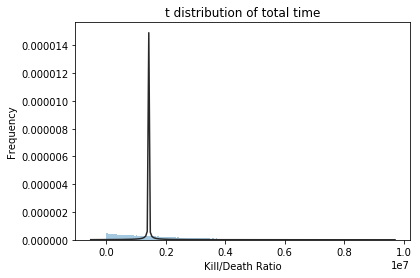

Estimated parameters for Lognorm distribution: 
11.674383059884594 
77.99999999999999 
19.17422657979948

 KstestResult(statistic=0.72592712494452416, pvalue=0.0) 
Loglikelihood: 1340460.484938296 
AIC: 2680926.969876592


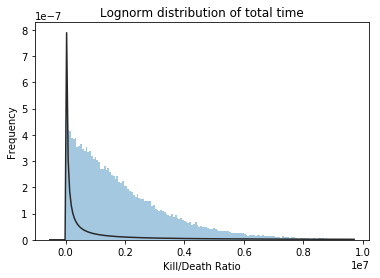

Estimated parameters for Gamma distribution: 
1.1244697459790514 
-75.8349171235837 
1711276.1142620542

 KstestResult(statistic=0.021963571807934068, pvalue=5.3364414918418612e-32) 
Loglikelihood: 1165413.6545775693 
AIC: 2330833.3091551387


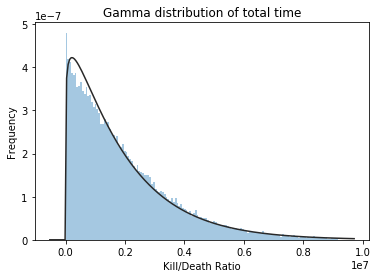

Estimated parameters for Skewnorm distribution: 
2296043953.2897906 
77.99554209619666 
2549437.1684781164


KeyboardInterrupt: 

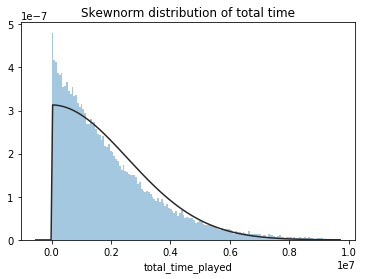

In [317]:
data = total_time_played_without_outlier
name = "total time"

plot_dists(data, name)

In [328]:
# call function to fit distributions to 'kill_death' data
distributions = [stats.beta, stats.expon,stats.norm,stats.logistic,stats.t,stats.chi2,
                 stats.dweibull,stats.lognorm,stats.gamma,stats.skewnorm,stats.f,stats.powerlaw]
df_fit = fitDist(distributions,total_time_played_without_outlier)
# order by loglik
df_fit_order = df_fit.copy()
print(df_fit_order.sort_values(by='loglik',ascending=True))

/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/weisihan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


        dist                                              parms       loglik
0       beta  (0.992121150058, 5.9390443196, 77.9999999999, ...  1.16484e+06
8      gamma     (1.12446974598, -75.8349171236, 1711276.11426)  1.16541e+06
9   skewnorm      (2296043953.29, 77.9955420962, 2549437.16848)  1.16627e+06
3   logistic                     (1703624.68054, 898831.329668)   1.1844e+06
6   dweibull      (1.18020456109, 1673749.83065, 1336613.80756)   1.1845e+06
11  powerlaw              (0.470822466982, 78.0, 9801907.74274)  1.18465e+06
5       chi2     (14909.4088716, -140049549.753, 9524.75155384)  1.18637e+06
2       norm                     (1924202.40571, 1672534.16744)  1.18673e+06
10         f  (1250595.60026, 1.11103803254, -5737.53763504,...  1.20253e+06
4          t      (0.12239897543, 1422239.23515, 719.555157945)  1.31288e+06
7    lognorm               (11.6743830599, 78.0, 19.1742265798)  1.34046e+06
1      expon                    (-203520924.427, 1855203.06828)  9.43232e+06

## 5. Headshot